In [1]:
import pandas as pd
import jsonlines
from tqdm import tqdm

#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = 
""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
#Paths
train_db_path='WikiSQL/data/train.db'
train_data_json_path='WikiSQL/data/train.jsonl'
train_table_json_path='WikiSQL/data/train.tables.jsonl'


dev_db_path='WikiSQL/data/dev.db'
dev_data_json_path='WikiSQL/data/dev.jsonl'
dev_table_json_path='WikiSQL/data/dev.tables.jsonl'

test_db_path='WikiSQL/data/test.db'
test_data_json_path='WikiSQL/data/test.jsonl'
test_table_json_path='WikiSQL/data/test.tables.jsonl'

In [3]:
def get_col_tokens(table_json_path):
    tokens=[]
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            for header in obj['header']:
                tokens.append(header)
    return tokens

In [4]:
def get_question_tokens(data_json_path):
    tokens=[]
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            tokens.append(obj['question'])
    return tokens

In [5]:
texts=[]
texts.extend(get_col_tokens(train_table_json_path))
texts.extend(get_col_tokens(dev_table_json_path))
texts.extend(get_col_tokens(test_table_json_path))

18585it [00:00, 38364.54it/s]
2716it [00:00, 37284.04it/s]
5230it [00:00, 33060.86it/s]


In [6]:
texts.extend(get_question_tokens(train_data_json_path))
texts.extend(get_question_tokens(dev_data_json_path))
texts.extend(get_question_tokens(test_data_json_path))

56355it [00:00, 152592.96it/s]
8421it [00:00, 126513.75it/s]
15878it [00:00, 125344.49it/s]


In [7]:
tokenizer=Tokenizer(char_level=True,lower=True)
tokenizer.fit_on_texts(texts)

In [8]:
max_token_index=len(tokenizer.index_word.keys())+1
max_token_index

1246

In [9]:
def text2seq(text):
    return np.ravel([tokenizer.texts_to_sequences([text])])

In [10]:
max_len=0
for text in texts:
    if len(text2seq(text))>max_len:
        max_len=len(text2seq(text))
max_len

419

In [11]:
def text2seq(text):
    return np.ravel(pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=max_len,padding='post'))

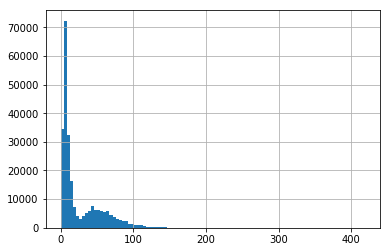

In [12]:
df = pd.Series(texts)
df.str.len().hist(bins=100)
plt.show()

In [13]:
del texts

In [14]:
#make a dict to keep track of all the columns of all the tables
def get_table(table_json_path):
    tables={}
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            tables[obj['id']]={'headers':[],'types':[]}
            tables[obj['id']]['headers']=obj['header']
            tables[obj['id']]['types']=obj['types']
    return tables

In [15]:
train_tables=get_table(train_table_json_path)
dev_tables=get_table(dev_table_json_path)
test_tables=get_table(test_table_json_path)

18585it [00:00, 27779.56it/s]
2716it [00:00, 32641.53it/s]
5230it [00:00, 20217.95it/s]


In [16]:
def get_dataset(data_json_path,table):
    #read the jsonl file
    X=[]
    y=[]
    global tokenizer
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            question=obj['question']
            N_cols=len(obj['sql']['conds'])
    
            #tokenized representation
            question=text2seq(question)
    
            
            X.append(question)
            y.append(N_cols)
            
    return X,y

In [17]:
X_train,y_train=get_dataset(train_data_json_path,train_tables)

56355it [00:03, 17094.07it/s]


In [18]:
X_dev,y_dev=get_dataset(dev_data_json_path,dev_tables)

8421it [00:00, 9503.62it/s]


In [19]:
from sklearn.utils.class_weight import compute_class_weight
class_weight=compute_class_weight('balanced',np.unique(y_train),y_train)
class_weight

array([26.64539007,  0.28829036,  0.8445227 ,  3.73335542, 23.92993631])

In [20]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_dev=lb.transform(y_dev)

In [21]:
from joblib import dump, load
dump(lb,'lb_k.joblib')

['lb_k.joblib']

In [22]:
y_train.shape

(56355, 5)

In [23]:
y_train.cumsum(axis=0)

array([[    0,     1,     0,     0,     0],
       [    0,     2,     0,     0,     0],
       [    0,     3,     0,     0,     0],
       ...,
       [  423, 39094, 13346,  3019,   471],
       [  423, 39095, 13346,  3019,   471],
       [  423, 39096, 13346,  3019,   471]])

In [24]:
#dimension
d=64
from keras.models import Model
from keras.layers import Input, GRU, Dense ,Flatten , Concatenate,Bidirectional
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers

In [25]:
# Define an input sequence and process it.
question_input = Input(shape=(max_len,),name='Q_input')

embedding= Embedding(max_token_index, d, input_length=max_len,name='embedding')
# embedding_C= Embedding(max_token_index, d, input_length=max_len,name='embedding_C')
#                      embeddings_constraint=max_norm(2.),
#                      embeddings_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))

Q_embedding= embedding(question_input)



encoder_question = Bidirectional(GRU(d, return_state=True))
_ , Q_state_h1, Q_state_h2 = encoder_question(Q_embedding)


con=Concatenate()([Q_state_h1,Q_state_h2])


final=Dense(5,activation='softmax')(con)

model = Model(question_input, final)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 419, 64)      79744       Q_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 128), (None, 49536       embedding[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]            
__________

In [26]:
from keras import backend as K

def first_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 0), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def second_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 1), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc



def third_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 2), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def fourth_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 3), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def fifth_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 4), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc



In [27]:
from keras import optimizers

opt = optimizers.Adam()

In [28]:
# Run training
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy',
                                                                     first_class_accuracy,
                                                                     second_class_accuracy,
                                                                     third_class_accuracy,
                                                                     fourth_class_accuracy,
                                                                     fifth_class_accuracy])

In [29]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='where_k_best_model.h5', monitor='val_loss', save_best_only=True)]

In [32]:
history=model.fit([X_train], y_train,batch_size=batch_size, epochs=epochs, verbose=1,class_weight=class_weight,
                callbacks=callbacks, validation_data=([X_dev],y_dev))

Train on 56355 samples, validate on 8421 samples
Epoch 1/100
56355/56355 [==============================] - 761s 14ms/step - loss: 0.7949 - acc: 0.7104 - first_class_accuracy: 0.0000e+00 - second_class_accuracy: 0.7254 - third_class_accuracy: 0.1333 - fourth_class_accuracy: 0.0000e+00 - fifth_class_accuracy: 1.7745e-05 - val_loss: 0.5147 - val_acc: 0.8037 - val_first_class_accuracy: 0.0000e+00 - val_second_class_accuracy: 0.8469 - val_third_class_accuracy: 0.5875 - val_fourth_class_accuracy: 0.0000e+00 - val_fifth_class_accuracy: 0.0000e+00
Epoch 2/100
56355/56355 [==============================] - 585s 10ms/step - loss: 0.4668 - acc: 0.8284 - first_class_accuracy: 0.0000e+00 - second_class_accuracy: 0.8810 - third_class_accuracy: 0.6957 - fourth_class_accuracy: 0.5675 - fifth_class_accuracy: 0.0000e+00 - val_loss: 0.4177 - val_acc: 0.8479 - val_first_class_accuracy: 0.0000e+00 - val_second_class_accuracy: 0.8880 - val_third_class_accuracy: 0.6778 - val_fourth_class_accuracy: 0.5683 - 

56355/56355 [==============================] - 280s 5ms/step - loss: 0.2464 - acc: 0.9143 - first_class_accuracy: 0.4047 - second_class_accuracy: 0.9373 - third_class_accuracy: 0.8611 - fourth_class_accuracy: 0.8421 - fifth_class_accuracy: 0.4531 - val_loss: 0.2565 - val_acc: 0.9109 - val_first_class_accuracy: 0.2136 - val_second_class_accuracy: 0.9306 - val_third_class_accuracy: 0.7883 - val_fourth_class_accuracy: 0.6940 - val_fifth_class_accuracy: 0.3420
Epoch 19/100
56355/56355 [==============================] - 280s 5ms/step - loss: 0.2396 - acc: 0.9161 - first_class_accuracy: 0.3807 - second_class_accuracy: 0.9384 - third_class_accuracy: 0.8650 - fourth_class_accuracy: 0.8415 - fifth_class_accuracy: 0.4584 - val_loss: 0.2522 - val_acc: 0.9090 - val_first_class_accuracy: 0.2257 - val_second_class_accuracy: 0.9200 - val_third_class_accuracy: 0.8275 - val_fourth_class_accuracy: 0.6755 - val_fifth_class_accuracy: 0.3293
Epoch 20/100
56355/56355 [==============================] - 280s 

In [33]:
model.load_weights('where_k_best_model.h5')

In [34]:
X_test,y_test=get_dataset(test_data_json_path,test_tables)

15878it [00:01, 12212.17it/s]


In [35]:
model.evaluate([X_train],y_train,verbose=1)

56355/56355 [==============================] - 1524s 27ms/step


[0.16904792748890712,
 0.9428089787961956,
 0.1139443409339603,
 0.9598761487443669,
 0.8242653087679471,
 0.5462419574530295,
 0.14985952148581907]

In [37]:
y_test=lb.transform(y_test)

In [38]:
#new
model.evaluate([X_test],y_test,verbose=1)

15878/15878 [==============================] - 434s 27ms/step


[0.246676129603479,
 0.9168661040508382,
 0.11302850904815887,
 0.9437775950251055,
 0.7732375128885749,
 0.5273688061948546,
 0.13335012805978924]

In [39]:
model.evaluate([X_dev],y_dev,verbose=1)

8421/8421 [==============================] - 230s 27ms/step


[0.23135440445274713,
 0.9184182401210788,
 0.11653406167121877,
 0.9445704627373152,
 0.7823405096943938,
 0.5241680379549991,
 0.14630091438071488]

In [32]:
history=model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, verbose=1,
                            callbacks=callbacks, validation_data=dev_generator,
                            validation_steps=dev_steps,max_queue_size=10)

Epoch 1/100
881/880 [==============================] - 1199s 1s/step - loss: 0.7093 - acc: 0.7377 - first_class_accuracy: 0.0000e+00 - second_class_accuracy: 0.7681 - third_class_accuracy: 0.2859 - fourth_class_accuracy: 0.0566 - fifth_class_accuracy: 0.0000e+00 - val_loss: 0.4447 - val_acc: 0.8429 - val_first_class_accuracy: 0.0000e+00 - val_second_class_accuracy: 0.8749 - val_third_class_accuracy: 0.7741 - val_fourth_class_accuracy: 0.6106 - val_fifth_class_accuracy: 0.0000e+00
Epoch 2/100
881/880 [==============================] - 1197s 1s/step - loss: 0.4176 - acc: 0.8474 - first_class_accuracy: 0.0000e+00 - second_class_accuracy: 0.8963 - third_class_accuracy: 0.7305 - fourth_class_accuracy: 0.5999 - fifth_class_accuracy: 0.0023 - val_loss: 0.3813 - val_acc: 0.8603 - val_first_class_accuracy: 0.0000e+00 - val_second_class_accuracy: 0.8930 - val_third_class_accuracy: 0.7731 - val_fourth_class_accuracy: 0.7222 - val_fifth_class_accuracy: 0.0000e+00
Epoch 3/100
881/880 [=============

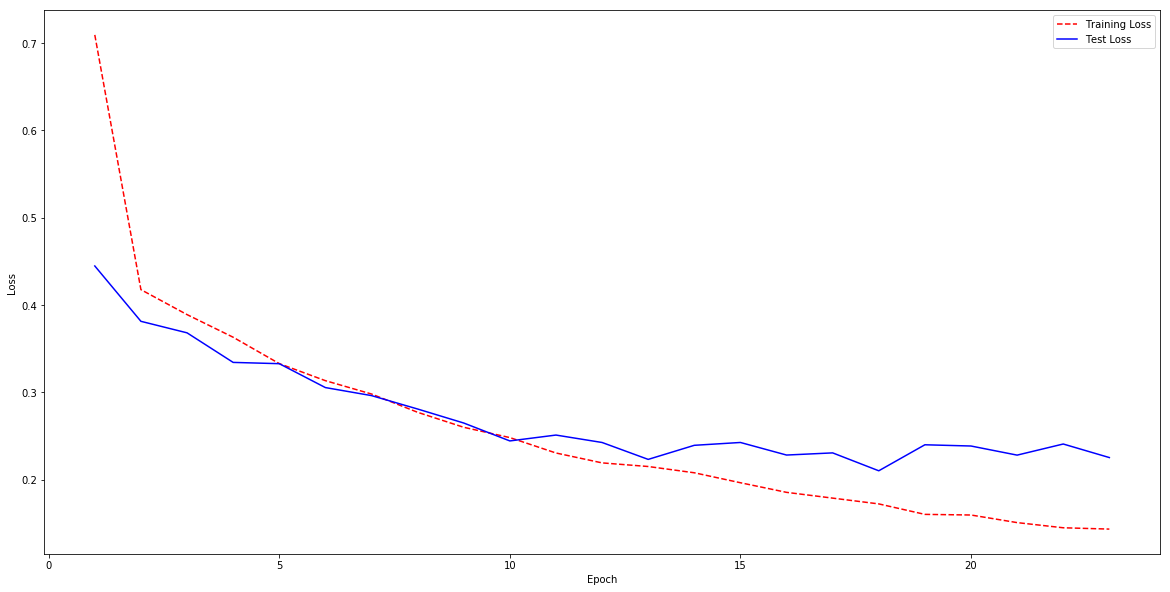

In [33]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

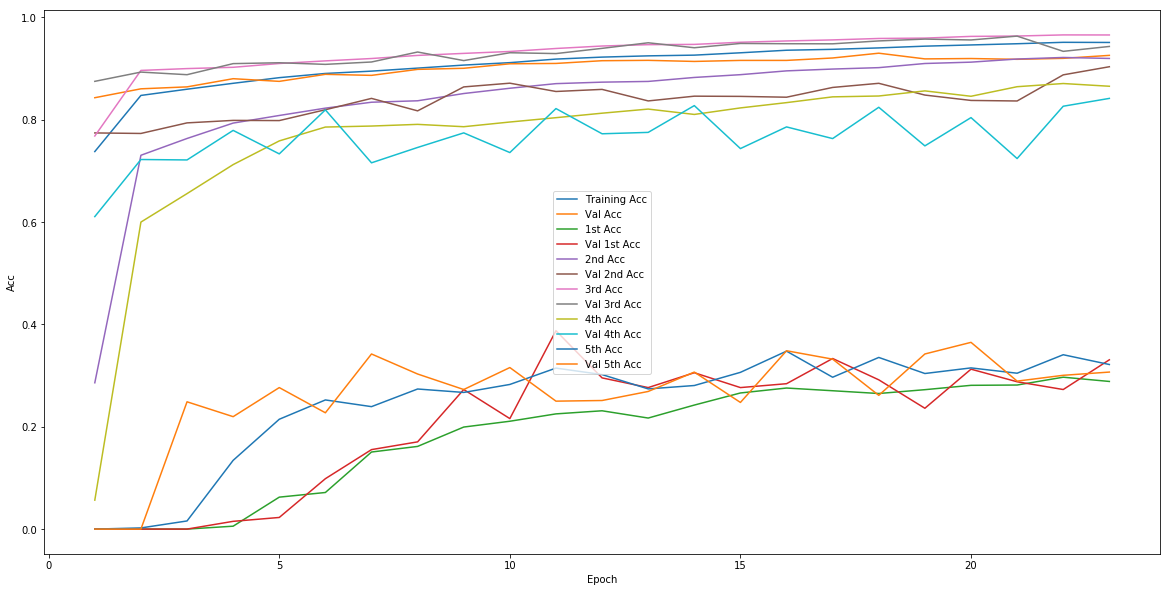

In [34]:

# Get training and test loss histories
training_acc = history.history['acc']
val_acc = history.history['val_acc']

training_one_acc = history.history['first_class_accuracy']
val_one_acc = history.history['val_first_class_accuracy']

training_second_acc = history.history['second_class_accuracy']
val_second_acc = history.history['val_second_class_accuracy']

training_third_acc = history.history['third_class_accuracy']
val_third_acc = history.history['val_third_class_accuracy']

training_fourth_acc = history.history['fourth_class_accuracy']
val_fourth_acc = history.history['val_fourth_class_accuracy']

training_fifth_acc = history.history['fifth_class_accuracy']
val_fifth_acc = history.history['val_fifth_class_accuracy']


# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_acc)
plt.plot(epoch_count, val_acc)

plt.plot(epoch_count, training_one_acc)
plt.plot(epoch_count, val_one_acc)

plt.plot(epoch_count, training_third_acc)
plt.plot(epoch_count, val_third_acc)

plt.plot(epoch_count, training_second_acc)
plt.plot(epoch_count, val_second_acc)

plt.plot(epoch_count, training_fourth_acc)
plt.plot(epoch_count, val_fourth_acc)

plt.plot(epoch_count, training_fifth_acc)
plt.plot(epoch_count, val_fifth_acc)


plt.legend(['Training Acc', 'Val Acc',
           '1st Acc','Val 1st Acc',
           '2nd Acc','Val 2nd Acc',
           '3rd Acc','Val 3rd Acc',
           '4th Acc','Val 4th Acc',
           '5th Acc','Val 5th Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show();